<a href="https://colab.research.google.com/github/nyp-sit/iti107/blob/main/session-2/xception_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical Exercise (Optional): Create Modern Modular Network 

In this exercise, you are going to make use of some architecural elements that you learnt, such as residual connection, and separable convolution, and combine them into a building block, and use this building block to construct a modular network. 

This building block is similar to what [Xception](https://arxiv.org/abs/1610.02357) is using. 

Here is the simplified view of our network: 

![xception](https://nyp-aicourse.s3.ap-southeast-1.amazonaws.com/iti107/resources/mini_xception.png)

In [1]:
import tensorflow as tf
import tensorflow.keras as keras


**Exercise 1 - Define the Xception block**

Let us the define our xception block first. Here are the steps you will need to do: 
1. First save the output from previous block (or if this is the first block, then output from previous convolutional/maxpooling layer) and use this as residual to be added later
2. Add the 2 [separable convolutional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SeparableConv2D) and the maxpool layer. For MaxPooling,  use a stride size of 2. Add BatchNormalization after each separable convolutional layer and before the Activation layer.
3. Use 1x1 conv to adjust the size and channels of the residual to match the output from MaxPooling layer. To adjust the size, you can specify the stride size of 2. 
4. To add the the residual with the output from MaxPooling layer, you can use the [`keras.layers.add()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add).
5. As recommended by author of ResNet, the residual should be added before the Activation function. 

Use 'same' padding throughout the block.

In [2]:
def xception_block(x, depth): 
    """
    Parameters:
    -----------
    x: output from the previous block or previous layer, considered as input to this Xception block
       it is a tensor of shape (batch, h, w, channels)
    depth: number of channels, it is an int value
    """
    
    # save input to be used as skip connection
    residual = x
    
    # add the first separable convolutional 2D layer (as well as the batch normalization and activation layer)
    x = keras.layers.SeparableConv2D(depth, 3, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    
    # add the second separable convolutional 2D layer (as well as the batch normalization BUT without activation layer)
    x = keras.layers.SeparableConv2D(depth, 3, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    
    # add the maxpooling 2d layer, with stride of 2
    x = keras.layers.MaxPool2D(3, strides=2, padding='same')(x)
    
    # adjust the size and depth using 1x1 convolution to match the output from last maxpooling layer. Use strides=2 to match the output from maxpooling
    residual = keras.layers.Conv2D(depth, 1, strides=2, padding='same')(residual)
    
    # add back the residual to the output from maxpooling layer
    x = keras.layers.add( [x, residual] )
    
    # add the activation layer
    x = keras.layers.Activation('relu')(x)
    
    return x # Set aside next residual

**Exercise 2: Build the complete network using Xception blocks**

We will then build our complete network using the xception block defined in the previous exercise: 
1. Define the input layer with appropriate shape
2. Define a rescaling layer to normalize the input to between (0,1)
3. Define the entry blocks that consist of one Conv2D layer with the stride size of 2 and another Conv2D layer with stride size of 1. Remember to add BatchNormalization after each convolutional layer and before Activation layer.
4. Add the series of xception blocks, with different depths `[128,256,512,728]`
5. Add the last Separable convolutional 2D layer. Remember to add BatchNormalization layer before the Activation layer.
6. Add GlobalAveragePooling2D layer before connected to output Dense Layer
7. Use Dropout for the dense layer 

Use 'same' padding throughout the network.



In [3]:
def make_model(input_shape, num_classes): 

    inputs = keras.Input(shape=input_shape)

    # add resclaing 
    x = keras.layers.Rescaling(1./255)(inputs)
    
    # Entry blocks

    # 1st conv2d with strides = 2
    x = keras.layers.Conv2D(32, 3, strides=2, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    # 2nd conv2d with strides = 1
    x = keras.layers.Conv2D(64, 3, strides=1, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    
    # build a series of xception blocks with different depth
    for depth in [128, 256, 512, 728]:
        x = xception_block(x, depth)
    
    # add SeparableConv2D
    x = keras.layers.SeparableConv2D(1024, 3, padding='same')(x)

    # add Global Average Pooling layer before connecting to Dense layer 
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.5)(x)
    
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    
    return keras.Model(inputs, outputs)

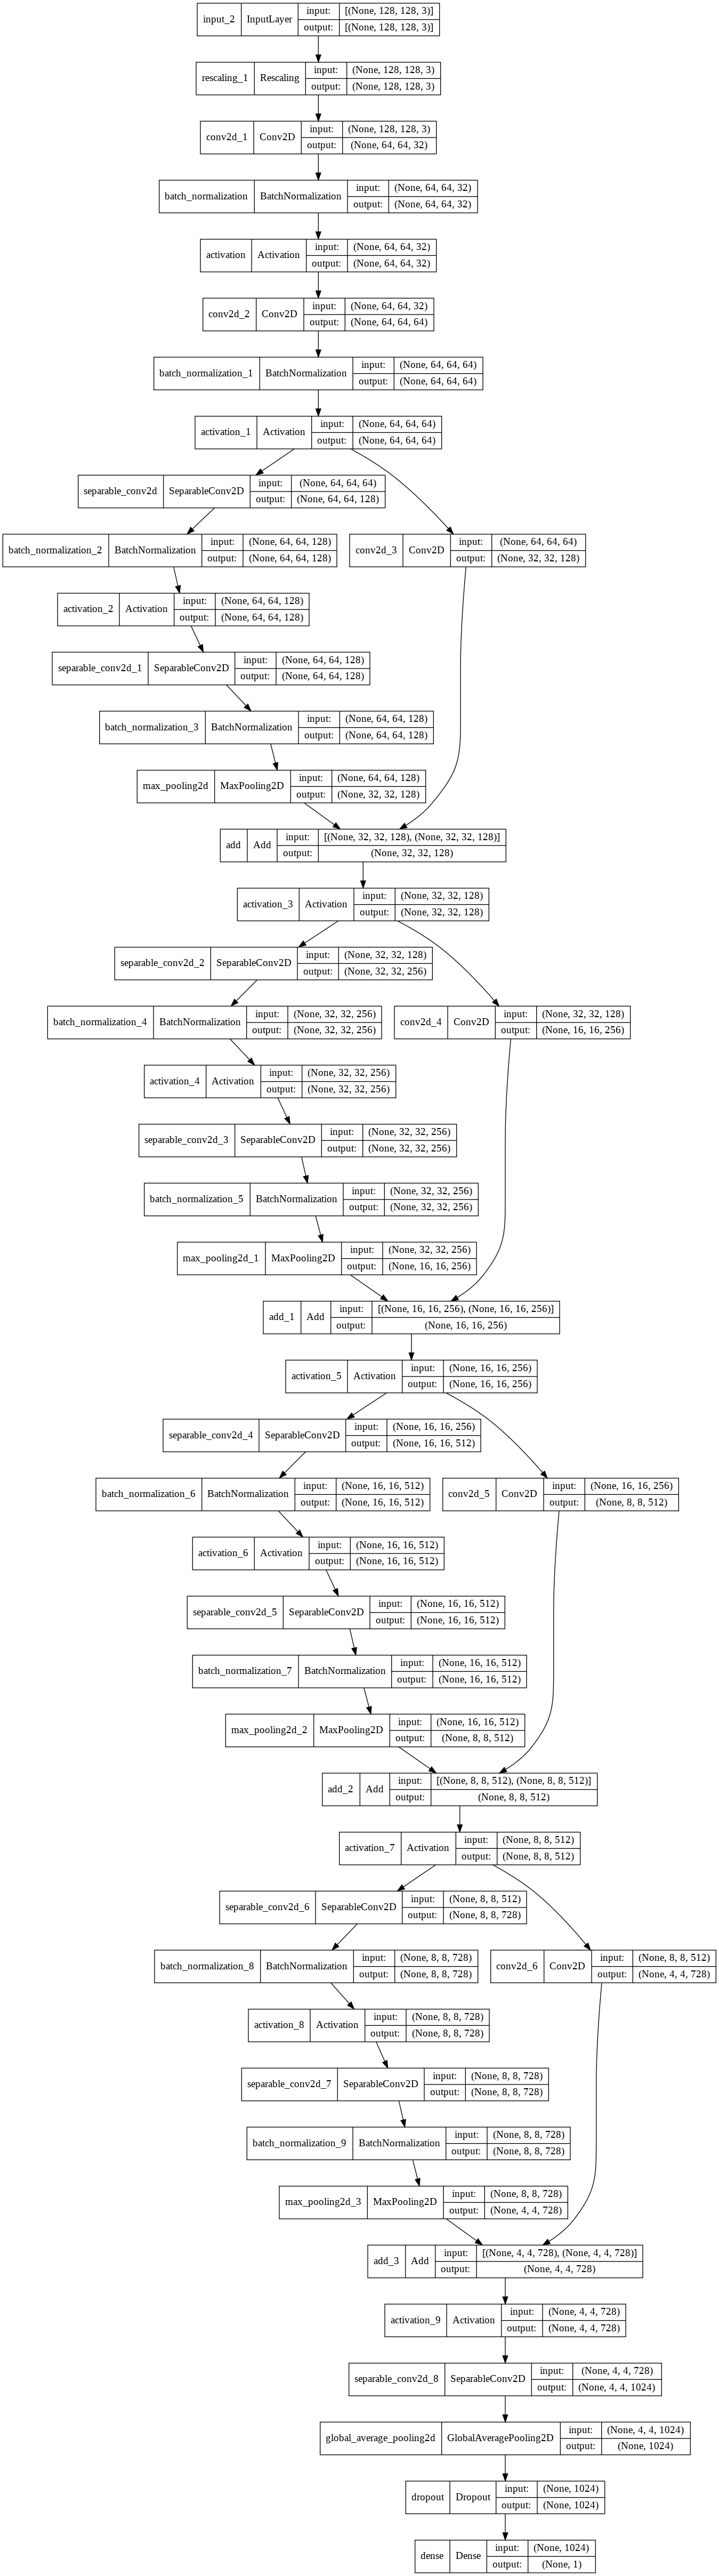

In [5]:
image_size = (128,128)

model = make_model(input_shape= image_size + (3,), num_classes=2)

keras.utils.plot_model(model, show_shapes=True)

### Create train and validation dataset

We will go ahead and download the same dataset, and setup the training and validation dataset.

In [6]:
import os 

dataset_URL = 'https://nyp-aicourse.s3-ap-southeast-1.amazonaws.com/datasets/cats_and_dogs_subset.tar.gz'
tf.keras.utils.get_file(origin=dataset_URL, extract=True, cache_dir='.')
dataset_folder = os.path.join('datasets', 'cats_and_dogs_subset')

67051520/67041740 [==============================] - 7s 0us/step


In [7]:
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_folder,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_folder,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary'
)

Found 3000 files belonging to 2 classes.
Using 2400 files for training.
Found 3000 files belonging to 2 classes.
Using 600 files for validation.


Ok, everything is ready. Now we are ready to put our mini-xception network to test and see if perform better than our previous 'traditional' CNN architecture. 

In [8]:
def create_tb_callback(): 

    import os
    
    root_logdir = os.path.join(os.curdir, "tb_logs")

    def get_run_logdir():    # use a new directory for each run
        
        import time
        
        run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
        return os.path.join(root_logdir, run_id)

    run_logdir = get_run_logdir()

    tb_callback = tf.keras.callbacks.TensorBoard(run_logdir)

    return tb_callback

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_checkpoint",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


# compile our model with loss and optimizer 
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)


model.fit(
    train_ds, epochs=30, 
    validation_data=val_ds,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/30
150/150 [==============================] - 31s 128ms/step - loss: 0.6553 - accuracy: 0.6117 - val_loss: 0.6984 - val_accuracy: 0.4867
Epoch 2/30
150/150 [==============================] - 18s 121ms/step - loss: 0.6146 - accuracy: 0.6733 - val_loss: 0.7358 - val_accuracy: 0.4867
Epoch 3/30
150/150 [==============================] - 18s 122ms/step - loss: 0.5882 - accuracy: 0.6938 - val_loss: 1.0551 - val_accuracy: 0.4867
Epoch 4/30
150/150 [==============================] - 19s 123ms/step - loss: 0.5495 - accuracy: 0.7321 - val_loss: 0.7363 - val_accuracy: 0.6483
Epoch 5/30
150/150 [==============================] - 19s 123ms/step - loss: 0.5493 - accuracy: 0.7383 - val_loss: 0.6875 - val_accuracy: 0.6867
Epoch 6/30
150/150 [==============================] - 18s 121ms/step - loss: 0.4814 - accuracy: 0.7750 - val_loss: 0.6292 - val_accuracy: 0.6767
Epoch 7/30
150/150 [==============================] - 19s 123ms/step - loss: 0.4230 - accuracy: 0.8129 - val_loss: 0.6302 - val_ac

In [ ]:
best_checkpoint = 'bestc_heckpoint'

model.load_weights(best_checkpoint)
model.evaluate(val_ds)